In [1]:
!pip install -U ultralytics  # Обновление до последней версии

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00


In [2]:
!pip install imgviz pyyaml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.8 MB/s eta 0:00:00


In [3]:
# Подключаем библиотеки

# Визуализация данных данных
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Обработка данных
import numpy as np
import pandas as pd

# Работа с фотографиями
import imgviz
from PIL import Image

# Расчёт модели
import torch
import torch.nn as nn

from concurrent.futures import ThreadPoolExecutor # Паралельная обработка данных
import albumentations as A # Аугментация изображений
from ultralytics import YOLO # Библиотека моделей
import logging # Отслеживание работы
from sklearn.model_selection import train_test_split # Разделение датасета на train и val
from tqdm import tqdm # Визуализация процессов работы
import cv2 # Загрузка изображений
from shutil import copy # Копирование данных в каталоге
import os # Работа с операционной системой
from pathlib import Path # Взаимодействие с файлами и каталогами
import random # Добавляем немного случайности в программу

# import shutil


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 1. Провести предварительное исследование данных

- в каком формате вам предоставлены данные?
- какие есть особенности датасета?
- если необходимо произвести очистку и предварительную обработку данных.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


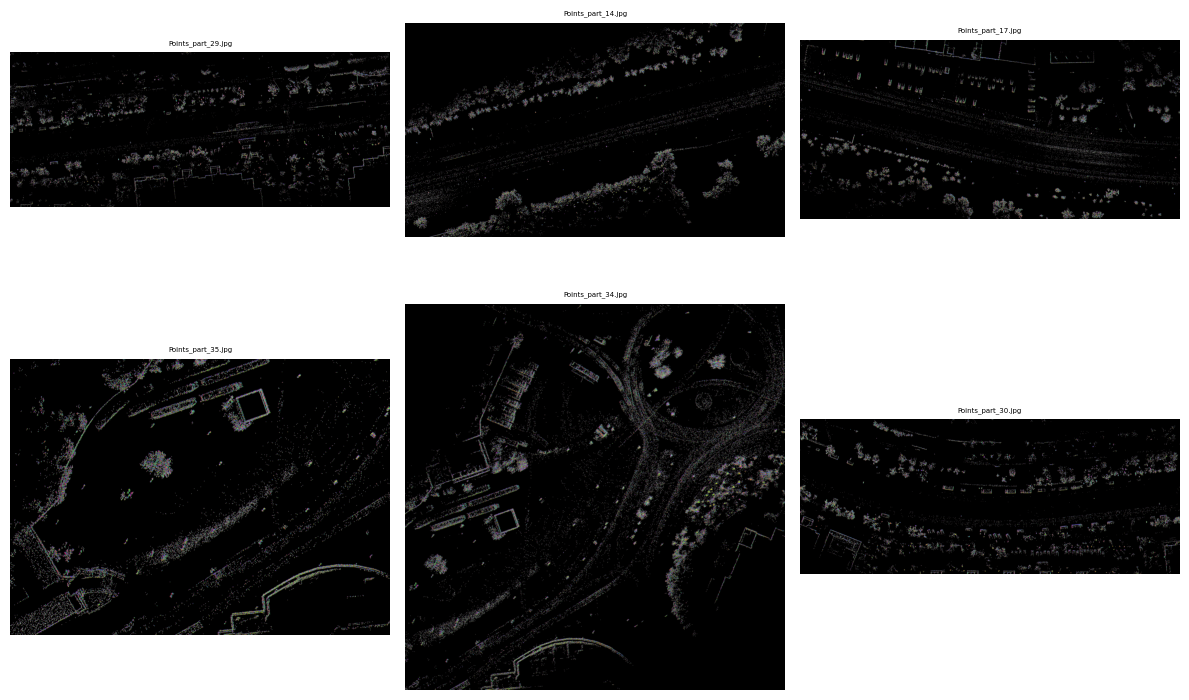

In [5]:
# === Папки с изображениями и разметкой ===
img_dir = '/content/drive/MyDrive/Colab Notebooks/data/train/images'
label_dir = '/content/drive/MyDrive/Colab Notebooks/data/train/labels'
# === Берем 6 любых изображения ===
image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg'))])
selected_images = random.sample(image_files, 6)

def draw_boxes(img_path, label_path):
    # Читаем изображение
    img = cv2.imread(img_path)

    h, w, _ = img.shape  # размер изображения

    # Если аннотации нет — просто возвращаем изображение
    if not os.path.exists(label_path):
        return img

    # Читаем аннотацию в формате YOLO
    with open(label_path, 'r') as f:
        lines = f.read().strip().split('\n')

    for line in lines:
        if not line:
            continue
        class_id, x_center, y_center, bw, bh = map(float, line.strip().split())

        # Переводим координаты из нормированных в пиксели (не надо)
        x_center #*= w
        y_center #*= h
        bw #*= w
        bh #*= h

        # Задаём цвета для различных классов
        colors = {
            0: (0, 255, 0),       # green
            1: (255, 0, 0),       # red
            2: (255, 0, 255),     # purple
            3: (255, 255, 0)}     # yellow

        # Задаём названия классов
        class_name = {
            0: "car",
            1: "train",
            2: "bus",
            3: "truck"}

        # Вычисляем координаты углов прямоугольников
        x1 = int(x_center - bw / 2)
        y1 = int(y_center - bh / 2)
        x2 = int(x_center + bw / 2)
        y2 = int(y_center + bh / 2)

        # Рисуем прямоугольник
        cv2.rectangle(img, (x1, y1), (x2, y2), color=colors[class_id], thickness=5)
        cv2.putText(img, class_name[class_id], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, colors[class_id], 4)

    return img

# === Отображаем изображения с разметкой ===
plt.figure(figsize=(12, 8))

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(img_dir, img_file)
    label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

    img_with_boxes = draw_boxes(img_path, label_path)

    plt.subplot(2,3, i+1)
    plt.imshow(img_with_boxes)
    plt.title(img_file, fontsize=5)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Считаем csv файлы из папки, запоминая их названия

labels_dir = Path('/content/drive/MyDrive/Colab Notebooks/data/train/labels')
data = []

# Собираем данные из всех текстовых файлов
for txt_file in labels_dir.glob('*.txt'):
    with open(txt_file, 'r') as f:
        # Читаем все строки файла
        file_data = []
        for line in f:
            # Преобразуем строку в список чисел
            values = list(map(float, line.strip().split()))
            file_data.append(values)

        # Добавляем запись в общий список
        data.append({
            'image': txt_file.stem,  # имя файла
            'detection': file_data   # информация в файле
        })

# Создаем датафрейм
annotations_df = pd.DataFrame(data)
annotations_df.head()

,image,detection
0,Points_part_12,[]
1,Points_part_9,[]
2,Points_part_15,[]
3,Points_part_16,[]
4,Points_part_10,[]


In [7]:

# Собираем данные
for txt_file in labels_dir.glob('*.txt'):
    with open(txt_file, 'r') as f:
        for line in f:
          # if not line:
          #   continue
          class_id, x_center, y_center, width, height = map(float, line.split())
          data.append({
              'image': txt_file.stem + '.jpg',
              'class_id': int(class_id),
              'x_center': x_center,
              'y_center': y_center,
              'width': width,
              'height': height
          })

df = pd.DataFrame(data)
objects_per_image = df.groupby('image').size().reset_index(name='object_count')
df = df.merge(df.groupby('image').size().reset_index(name='object_count'), on='image') # Добавляем информацию о количестве чаек на фото
df['bbox_area'] = df['width'] * df['height']  # Нормализованная площадь

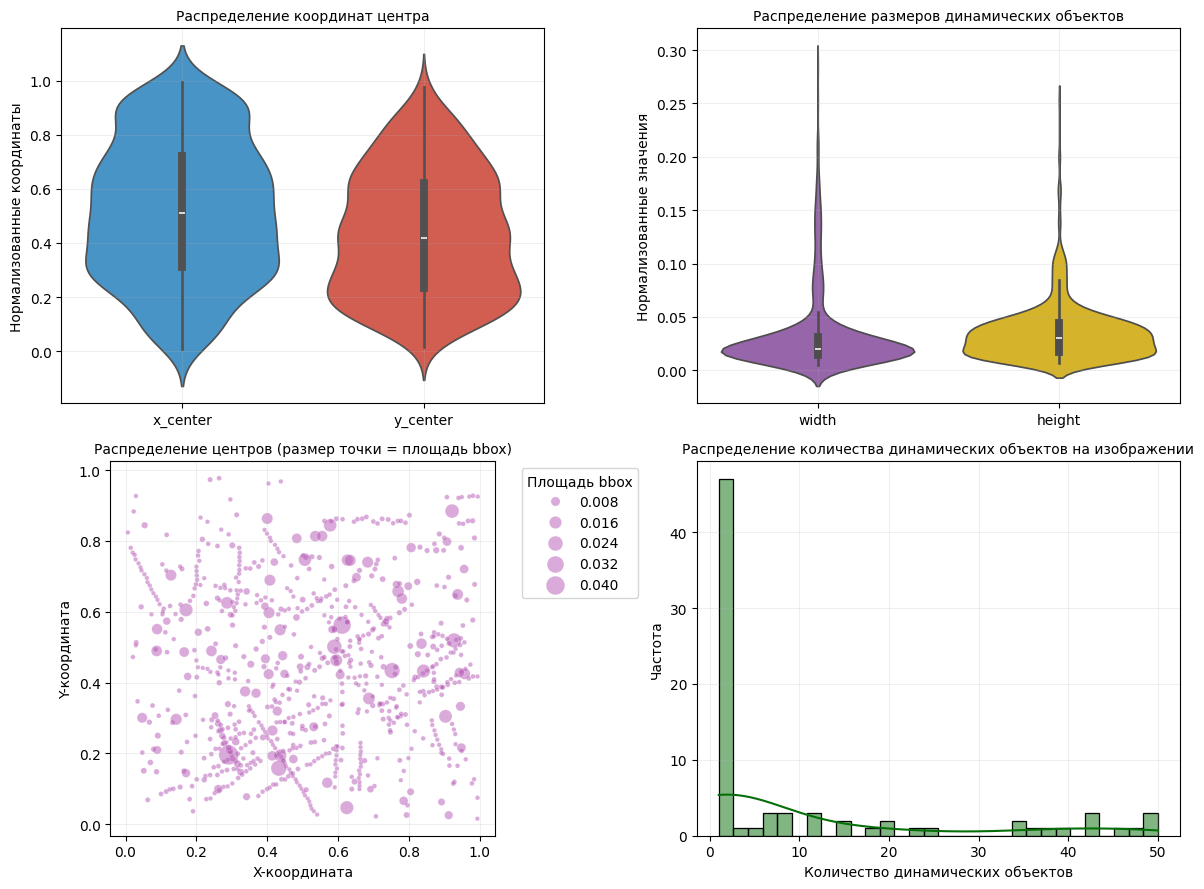

In [8]:
# Визуализируем распределение данных для предварительного исследования
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(12, 9))
gs = GridSpec(2, 2, figure=plt.gcf(), width_ratios=[1, 1])

# 1. Распределение координат центра (X и Y отдельно)
ax1 = plt.subplot(gs[0, 0])
sns.violinplot(data=df[['x_center', 'y_center']], palette=['#3498db', '#e74c3c'], ax=ax1)
ax1.set_title('Распределение координат центра', fontsize=10)
ax1.set_ylabel('Нормализованные координаты')
ax1.grid(alpha=0.2)

# 2. Распределение центров с размерами (размер точки = площадь bbox)
ax2 = plt.subplot(gs[1, 0])
sns.scatterplot(data=df, x='x_center', y='y_center',
                size='bbox_area', sizes=(10, 200),
                alpha=0.5, color='#b659b6', ax=ax2)
ax2.set_title('Распределение центров (размер точки = площадь bbox)', fontsize=10)
ax2.set_xlabel('X-координата')
ax2.set_ylabel('Y-координата')
ax2.set_aspect('equal')
ax2.grid(alpha=0.2)
ax2.legend(title='Площадь bbox', bbox_to_anchor=(1.05, 1))

# 3. Распределение размеров чаек (ширина и высота)
ax3 = plt.subplot(gs[0, 1])
sns.violinplot(data=df[['width', 'height']], palette=['#9b59b6', '#f1c40f'], ax=ax3)
ax3.set_title('Распределение размеров динамических объектов', fontsize=10)
ax3.set_ylabel('Нормализованные значения')
ax3.grid(alpha=0.2)

# 4. Распределение количества объектов на изображении (с квантилями)
ax4 = plt.subplot(gs[1, 1])
hist = sns.histplot(objects_per_image['object_count'], bins=30,
                    kde=True, color='#056e09', ax=ax4)

ax4.set_title('Распределение количества динамических объектов на изображении', fontsize=10)
ax4.set_xlabel('Количество динамических объектов')
ax4.set_ylabel('Частота')
ax4.grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [9]:
# Определение минимального и максимального значений для ширины bounding box
width_data_min = np.min(df['width'])
width_data_max = np.max(df['width'])

# Определение минимального и максимального значений для высоты bounding box
height_data_min = np.min(df['height'])
height_data_max = np.max(df['height'])

# Вывод максимального и минимального значений для ширины и высоты bounding box
print(f"Высота bounding box максимальная {height_data_max} и минимальная {height_data_min}")
print(f"Ширина bounding box максимальная {width_data_max} и минимальная {width_data_min}")

Высота bounding box максимальная 0.252717 и минимальная 0.007215
Ширина bounding box максимальная 0.284588 и минимальная 0.005018



*   Центр относительно равномерно распределён по X
*   По Y центр смещён в верзнюю часть изображения
*   Большинство bbox имеют небольшие размеры, в сравнении с размером изображения
*   Большинство bbox расположены в нижней части изображения и имеют малые размеры
*   Чаще всего на изображении присутствует 2-16 bbox


## 2. Подготовить данные для обучения

- Создать тренировочную и тестовую подвыборки для обучения и тестирования работы моделей
- Создать класс на фреймворке `PyTorch` для создания датасета
- Создать `loader` для передачи данных в модель нейронной сети

*P.s.: если вам удобнее использовать Keras или другой формат обработки данных и построения моделей, вы можете их использовать, не обязательно идти по пути `PyTorch` и `loader`.

In [10]:
# Программа, для чтения и работы с .txt файлами ответов
def read_yolo_annotations(txt_path):
    try:
        with open(txt_path, 'r') as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Ошибка чтения файла {txt_path}: {e}")
        return []

    annotations = []
    for line in lines:
        try:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                coords = list(map(float, parts[1:5]))
                annotations.append([class_id] + coords)
        except Exception as e:
            print(f"Ошибка обработки строки '{line}' в файле {txt_path}: {e}")
            continue

    return annotations

# Программа для записи разметки в YOLO формате
def write_yolo_annotations(txt_path, annotations):
    with open(txt_path, 'w') as f:
      for ann in annotations:
        if len(ann) == 5:
            line = f"{int(ann[0])} {ann[1]:.8f} {ann[2]:.8f} {ann[3]:.8f} {ann[4]:.8f}\n"
            f.write(line)

# Обработка изображения с помощью аугментации
def process_image(args):
    source_images_dir, source_labels_dir, dest_dir, split, file_name, augment = args

    # Пути для сохранения
    images_dest_dir = os.path.join(dest_dir, "images", split)
    labels_dest_dir = os.path.join(dest_dir, "labels", split)
    os.makedirs(images_dest_dir, exist_ok=True)
    os.makedirs(labels_dest_dir, exist_ok=True)

    # Загрузка оригинала
    img_path = os.path.join(source_images_dir, file_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Ошибка загрузки: {img_path}")
        return

    # Загрузка аннотаций
    base_name = os.path.splitext(file_name)[0]
    txt_path = os.path.join(source_labels_dir, base_name + '.txt')
    annotations = read_yolo_annotations(txt_path)

    # Для тренировочных данных: создаём оригинал + N аугментированных вариантов
    if augment and annotations:

        for i in range(num_augmentations + 1):  # +1 для сохранения оригинала
            # Генерируем уникальное имя файла
            if i == 0:
                new_img_name = f"{base_name}.jpg"  # Оригинал
                new_txt_name = f"{base_name}.txt"
            else:
                new_img_name = f"{base_name}_aug{i}.jpg"
                new_txt_name = f"{base_name}_aug{i}.txt"

            # Для аугментированных вариантов
            if i > 0:
                transform = A.Compose([
                    A.RandomBrightnessContrast(p=0.8),
                    A.RandomGamma(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.Affine(
                        scale=(0.9, 1.1),
                        translate_percent=0.05,
                        rotate=(-5, 5),
                        p=0.7
                    )
                ], bbox_params=A.BboxParams(format='yolo', min_visibility=0.3))

                bboxes = [[x,y,w,h] for _,x,y,w,h in annotations]
                transformed = transform(image=img.copy(), bboxes=bboxes)
                aug_img = transformed['image']
                aug_bboxes = transformed['bboxes']
                aug_annotations = [[ann[0]] + list(bbox) for ann, bbox in zip(annotations, aug_bboxes)]

            else:
                aug_img = img
                aug_annotations = annotations

            # Сохранение
            cv2.imwrite(os.path.join(images_dest_dir, new_img_name), aug_img)
            write_yolo_annotations(
                os.path.join(labels_dest_dir, new_txt_name),
                aug_annotations
            )

    # Для валидационных данных: просто копируем
    else:
        img = cv2.resize(img, (640, 640))
        cv2.imwrite(os.path.join(images_dest_dir, file_name), img)
        write_yolo_annotations(
            os.path.join(labels_dest_dir, base_name + '.txt'),
            annotations
        )



# Ключевая программа для считывания данных -> аугментации -> разделения на тренировочную и валидационную группы и разложения по папкам
def create_augmented_dataset(images_dir, labels_dir, new_dir, portion):
    # Ввод параметров
    source_images_dir = images_dir # Путь к папке с изображениями
    source_labels_dir = labels_dir # Путь к папке с разметкой (txt файлы)
    dest_dir = new_dir # Путь для сохранения датасета для обучения модели
    val_ratio = portion # Доля валидационных данных

    # Проверка существования папки для быстрого закрытия программы
    for path in [source_images_dir, source_labels_dir]:
        if not os.path.exists(path):
            print(f"Ошибка: папка {path} - не существует.")
            return

    # Создание структуры папок
    for folder in ["images/train", "images/val", "labels/train", "labels/val"]:
        os.makedirs(os.path.join(dest_dir, folder), exist_ok=True)

    # Сбор списка изображений
    image_files = [f for f in os.listdir(source_images_dir)
                  if f.lower().endswith('.jpg')]


    # Разделение данных с коэффициентом "val_ratio"
    train_files, val_files = train_test_split(
        image_files, test_size=val_ratio, random_state=42
    )
    print(f"Найдено файлов: {len(image_files)}")
    print(f"Тренировочные до аугментации: {len(train_files)}")
    print(f"Валидационные: {len(val_files)}")
    # Подготовка аргументов для обработки
    tasks = []

    # Добавляем в папку с трененровочными данными аугментированные элементы
    for file_name in train_files:
        tasks.append((source_images_dir, source_labels_dir, dest_dir, "train", file_name, True))

    # Добавляем в папку с валидационными данными только исходные элементы
    for file_name in val_files:
        tasks.append((source_images_dir, source_labels_dir, dest_dir, "val", file_name, False))

    # Параллельная обработка
    with ThreadPoolExecutor(max_workers=4) as executor:
        list(tqdm(executor.map(process_image, tasks), total=len(tasks)))

    print("\nДатасет успешно создан!")
    print(f"Путь: {dest_dir}")

In [11]:
# Путь к исходным данным
img_dir = '/content/drive/MyDrive/Colab Notebooks/data/train/images'
ann_dir = '/content/drive/MyDrive/Colab Notebooks/data/train/labels'

# Путь для сохранения аугментированного датасета
dest_dir = '/content/drive/MyDrive/Colab Notebooks/yoloH'


# # Количество аугментированных изображений для расширения набора данных
num_augmentations = 0
# Создаем аугментированный датасет
create_augmented_dataset(images_dir = img_dir, labels_dir = ann_dir, new_dir = '/content/drive/MyDrive/Colab Notebooks/yoloH', portion=0.25)

Найдено файлов: 42
Тренировочные до аугментации: 31
Валидационные: 11


100%|██████████| 42/42 [00:33<00:00,  1.26it/s]


Датасет успешно создан!
Путь: /content/drive/MyDrive/Colab Notebooks/yoloH


Тренировочные файлы: 35.
Валидационные файлы: 14.


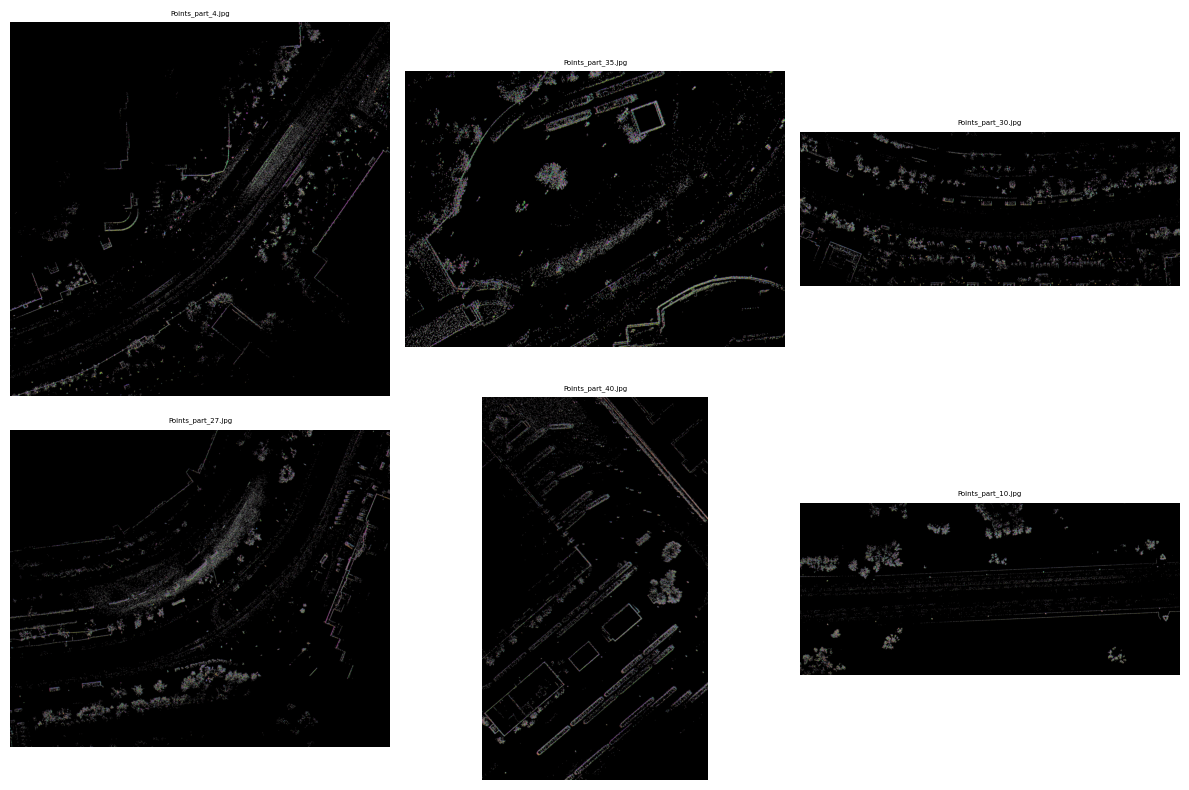

In [12]:
# === Папки с изображениями и разметкой ===
img_dir_t = '/content/drive/MyDrive/Colab Notebooks/yoloH/images/train'
label_dir_t = '/content/drive/MyDrive/Colab Notebooks/yoloH/labels/train'

img_dir_v = '/content/drive/MyDrive/Colab Notebooks/yoloH/images/val'
label_dir_v = '/content/drive/MyDrive/Colab Notebooks/yoloH/labels/val'

train_files = os.listdir(os.path.join(dest_dir, img_dir_t))
print(f"Тренировочные файлы: {len(train_files)}.")
val_files = os.listdir(os.path.join(dest_dir, img_dir_v))
print(f"Валидационные файлы: {len(val_files)}.")


# === Берем 6 любых изображения ===
image_files = sorted([f for f in os.listdir(img_dir_t) if f.endswith(('.jpg'))])
selected_images = random.sample(image_files, 6)

# === Отображаем изображения с разметкой ===
plt.figure(figsize=(12, 8))

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(img_dir, img_file)
    label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

    img_with_boxes = draw_boxes(img_path, label_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img_with_boxes)
    plt.title(img_file, fontsize=5)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# загрузка необходимых библиотек
import yaml

# Данные для конфигурации YOLO
data = {
    'train': '/content/drive/MyDrive/Colab Notebooks/yoloH/images/train',  # путь к обучающим изображениям
    'val': '/content/drive/MyDrive/Colab Notebooks/yoloH/images/val',  # путь к изображениям для валидации
    'nc': 4,
    'names': ["Car","Train","Bus","Truck"]
}

# Сохранение данных в YAML файл
with open('/content/drive/MyDrive/Colab Notebooks/yoloH/yolo_config.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, allow_unicode=True)

print("YAML файл успешно создан!")

YAML файл успешно создан!


## 3. Реализация модели

- создать класс для модели
- создать функцию для обучения модели
- создать функцию для валидации модели

In [50]:

Epoch = 2 # Количество эпох

# Настройка логгов
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def train(model_name, data_yaml):
    model = YOLO(model_name)
    best_map50 = 0
    best_model_wts = None # лучшая модель


    # Указываем  функцию потерь
    model.loss = nn.CrossEntropyLoss()

    for epoch in range(Epoch):
        print(f'Epoch number {epoch}')
        '''
        training_results = model.train(
            data=data_yaml,
            epochs=1,  # Обучение за одну эпоху
            imgsz=640,
            batch=32,
            device=0,
            augment=True,
            optimizer='Adam',
            lr0=0.01,
            lrf=0.0001,
        )
        '''
        training_results = model.train(
            data=data_yaml,
            epochs=30,  # Обучение за 2 эпох
            imgsz=1280,
            batch=4,
            device=0,
            augment=True,
            optimizer='Adam',
            lr0=0.001,
            lrf=0.00002,
        )
        #current_map50 = training_results.get('metrics/map50', 0)
        current_map50 = training_results.stats.get('metrics/map50', 0)

        logger.info(current_map50)

        # Сохранение лучших весов
        if current_map50 > best_map50:
            best_map50 = current_map50
            best_model_wts = model.state_dict()  # Сохранение лучших весов
            torch.save(best_model_wts, '/content/drive/MyDrive/best_model.pth')
            logger.info('Best model saved.')

In [51]:
# print(f"Используется памяти GPU: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
# print(f"Зарезервировано памяти: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")
# !nvidia-smi  # Показывает общую загрузку GPU

In [52]:
import gc

try:
    # Ваш код обучения
    train("yolov8m.pt", "/content/drive/MyDrive/Colab Notebooks/yoloH/yolo_config.yaml")
except Exception as e:
    print(f"!!!!!!!!!!!!Ошибка: {e}")
finally:
    # Принудительная очистка
    gc.collect()  # Сборщик мусора Python
    torch.cuda.empty_cache()  # Очистка CUDA

Epoch number 0
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/yoloH/yolo_config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=2e-05, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train12, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, p

In [41]:
torch.cuda.empty_cache()

## 5. Экспериментальная часть

In [18]:
test_path = r'/content/drive/MyDrive/Colab Notebooks/data/test/images'
test_images = sorted(glob.glob(os.path.join(test_path, '*.jpg')))
print(f"Найдено {len(test_images)} изображений в test выборке")

def make_submission_yolo(model, test_images, filename, visualize_n=3):
    # Генерация submission-файлов для YOLO
    submission = []

    results_pred = model.predict(test_images, imgsz=640, conf=0.5, verbose=False, batch=16)

    for idx, res in enumerate(results_pred):
        img_path = test_images[idx]
        pred_boxes = res.boxes
        if len(pred_boxes) == 0:
            bbox_str = "-1"
        else:
            bbox_str = ""
            for box in pred_boxes:
                x_center, y_center, width, height = box.xywhn[0].tolist()
                bbox_str += f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f} "
            bbox_str = bbox_str.strip()

        submission.append({
            "index": idx,
            "filename": os.path.basename(img_path),
            "bbox": bbox_str
        })

        if idx < visualize_n and bbox_str != "-1":
            res.show()

    pd.DataFrame(submission).to_csv(filename, index=False)
    print(f"Сохранён {filename}")

make_submission_yolo(results['YOLOv5l']['model'], test_images, "submission2_yolov5m.csv")
make_submission_yolo(results['YOLOv8l']['model'], test_images, "submission2_yolov8s.csv")

print("\nВсе submission-файлы готовы!")